In [265]:
from utils import *
import pandas as pd
import numpy as np
from post_process import PostProcess
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.ticker import ScalarFormatter

font_size = 14
label_font_size = 18

font_style = "Arial"
mpl.rcParams['font.family'] = font_style
mpl.rcParams['font.size'] = font_size 

# Load systematic data

In [266]:
annual_maxima_csv = r"C:\ISYE6420\Homework\Project\data\OC_Dam.csv"

df = pd.read_csv(annual_maxima_csv)
df["zstd"] = -norm.ppf(df["Plotting_Position"])
data = df["Flow"].to_xarray()

time_index = np.arange(len(data))

## Define quantiles for calculation

In [267]:
quantiles = [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 
             0.9, 0.95, 0.98, 0.99, 0.995, 0.998, 0.999, 0.9995, 0.9998,
             0.9999, 0.99995, 0.99998, 0.99999, 0.999995, 0.999998, 
             0.999999] 

x_values_z_scores = [-norm.ppf(1 - x) for x in quantiles]

## Stationary

In [268]:
samples_csv = r"C:\ISYE6420\Homework\Project\data\OCD\OCD_bayesian_stationary_lp3_summaries.csv"
summaries_lp3 = pd.read_csv(samples_csv)
posterior_mode = summaries_lp3.loc[summaries_lp3['LogLikelihood'].idxmax()]
mu_slp3 = posterior_mode['mu']
sigma_slp3 = posterior_mode['sigma']
gamma_slp3 = posterior_mode['gamma']
print("\nPosterior mode:\n")
print(f"mu: {mu_slp3}")
print(f"sigma: {sigma_slp3}")
print(f"gamma: {gamma_slp3}")

# Calculate the quantiles for the LP3 distribution
flood_quantiles_slp3 = [lp3_ppf(p, mu=mu_slp3, sigma=sigma_slp3, gamma_val=gamma_slp3) for p in quantiles]


Posterior mode:

mu: 1.302558936058672
sigma: 0.6994182638972732
gamma: 0.1778301048768925


## Non-stationary: $\mu$ linear tend

### Define selected year for analysis

In [269]:
selected_year_list = [1919, 1929, 1939, 1949, 1959, 1969, 1979, 1989, 1999, 2009, 2019, 2029, 2039, 2049]
colors = cm.plasma(np.linspace(0.9, 0.1, len(selected_year_list)))

start_year = 1915

### Posterior mode

In [270]:
ns_samples_csv = r"C:\ISYE6420\Homework\Project\data\OCD\OCD_bayesian_linear_mu_lp3_summaries.csv"
ns_summaries_lp3 = pd.read_csv(ns_samples_csv)
ns_posterior_mode = ns_summaries_lp3.loc[ns_summaries_lp3['LogLikelihood'].idxmax()]
beta0_nslp3 = ns_posterior_mode['beta_0']
beta1_nslp3 = ns_posterior_mode['beta_1']
sigma_nslp3 = ns_posterior_mode['sigma']
gamma_nslp3 = ns_posterior_mode['gamma']
print("\nPosterior mode:\n")
print(f"beta0: {beta0_nslp3}")
print(f"beta1: {beta1_nslp3}")
print(f"sigma: {sigma_nslp3}")
print(f"gamma: {gamma_nslp3}")


Posterior mode:

beta0: 1.86863297966136
beta1: -0.0107855759812721
sigma: 0.6138861848795376
gamma: -0.0476128134548506


### Plot distribution

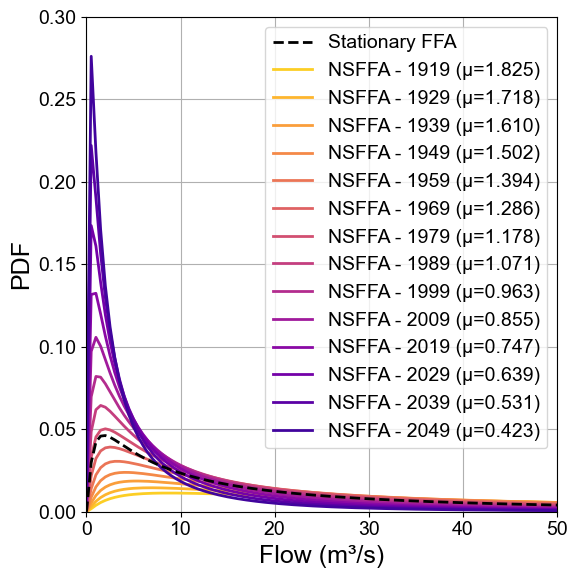

In [277]:
x_values = np.linspace(0.01, 500, 1000)

# Plotting the PDF
plt.figure(figsize=(6, 6))

lp3_pdf_values_s = lp3_pdf(x_values, mu=mu_slp3, sigma=sigma_slp3, gamma_val=gamma_slp3)
plt.plot(x_values, lp3_pdf_values_s, 
         linestyle="--",    
         color = "black",  linewidth=2,
         label=f"Stationary FFA", zorder =10)

# Loop through each year and plot the PDF
for year in selected_year_list:
    # Calculate mu_nslp3 for the current year
    mu_nslp3 = beta0_nslp3 + beta1_nslp3 * (year - start_year)
    
    # Compute the LP3 PDF values
    lp3_pdf_values_ns = lp3_pdf(x_values, mu=mu_nslp3, sigma=sigma_nslp3, gamma_val=gamma_nslp3)
    
    # Plot the PDF for the current year
    plt.plot(x_values, lp3_pdf_values_ns, 
             linewidth=2, color = colors[selected_year_list.index(year)],
             label=f"NSFFA - {year} (μ={mu_nslp3:.3f})")

plt.xlim(0, 50)
plt.ylim(0, 0.3)
plt.xlabel("Flow (m³/s)", fontsize=label_font_size, fontname=font_style)
plt.ylabel("PDF", fontsize=label_font_size, fontname=font_style)
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.savefig(r"C:\ISYE6420\Homework\Project\data\OCD\OCD_LP3_linear_mu_comparison_TI.png", dpi=300)

### Plot flood frequency curve

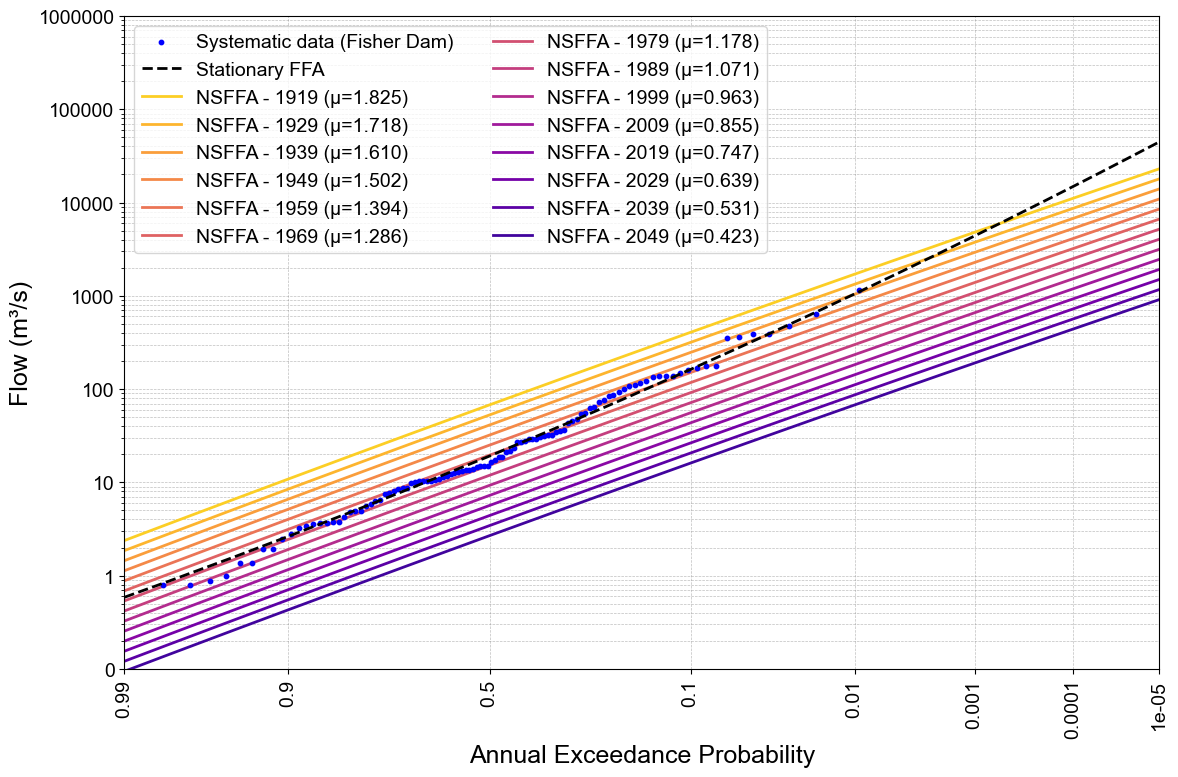

In [279]:
plt.figure(figsize=(12, 8))

plt.scatter(df['zstd'], df['Flow'], 
            s=10, color='blue', label='Systematic data (Fisher Dam)', zorder=10)

plt.plot(x_values_z_scores, flood_quantiles_slp3, 
         color = "black", linestyle='--', linewidth=2,
         label=f"Stationary FFA", zorder = 10)

# Loop through each year and plot the PDF
for year in selected_year_list:
    # Calculate mu_nslp3 for the current year
    mu_nslp3 = beta0_nslp3 + beta1_nslp3 * (year - start_year)
    
    # Compute the LP3 PDF values
    lp3_pdf_values_ns = lp3_pdf(x_values, mu=mu_nslp3, sigma=sigma_nslp3, gamma_val=gamma_nslp3)
    flood_quantiles_nslp3 = [lp3_ppf(p, mu=mu_nslp3, sigma=sigma_nslp3, gamma_val=gamma_nslp3) for p in quantiles]

    # Plot the PDF for the current year
    plt.plot(x_values_z_scores, flood_quantiles_nslp3, 
             linewidth=2, color = colors[selected_year_list.index(year)],
             label=f"NSFFA - {year} (μ={mu_nslp3:.3f})")
    
# cut off values for major ticks, and their corresponding z-scores
aep_lst = [0.99, 0.9, 0.5, 0.1, 0.01, 0.001, 0.0001, 0.00001]
major_z_scores = [-norm.ppf(aep) for aep in aep_lst]
x_ticks = [str(aep) for aep in aep_lst]

plt.xticks(major_z_scores, x_ticks, rotation = 90)
plt.grid(which='both', color='grey', linestyle='--', linewidth=0.5, alpha=0.5)

plt.yscale('log')
y_values = [0.1, 1, 10, 100, 1000, 10000, 100000, 1000000]
y_ticks = [str(i) for i in y_values]
plt.yticks(y_values, y_ticks)

plt.xlim(major_z_scores[0], major_z_scores[-1])
plt.ylim(y_values[0], y_values[-1])

ax = plt.gca()
formatter = ScalarFormatter()
formatter.set_scientific(False)
ax.yaxis.set_major_formatter(formatter) 

# set labels for x and y axes
plt.xlabel('Annual Exceedance Probability', fontsize=label_font_size, fontname=font_style)
plt.ylabel("Flow (m³/s)", fontsize=label_font_size, fontname=font_style)
plt.legend(loc="upper left", ncol = 2)
plt.tight_layout()
plt.savefig(r"C:\ISYE6420\Homework\Project\data\OCD\OCD_bayesian_flood_quantiles_lp3_linear_mu_TI.png", dpi=300)